# Aim

Figure out what is even *happening* with the SEAL LQG run where I put on a vibration peak that clearly dominates

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
from src import *

Running in simulation mode.
Updated the flat image.


In [5]:
times = np.load("../data/lqg/lqg_time_stamp_03_11_2021_15_40_23.npy")
commands = np.load("../data/lqg/lqg_cmd_stamp_03_11_2021_15_40_23.npy")[:,:2]
zerns = np.load("../data/lqg/lqg_z_stamp_03_11_2021_15_40_23.npy")[:,:2]

I guess the first thing to do would be to plot the Zernikes

In [13]:
def plot_tiptilt(data, n=10000):
    for i in range(2):
        plt.plot(times[:n], data[:n, i], label=f"Mode {i}")
    plt.legend()

Text(0.5, 1.0, 'LQG control residuals')

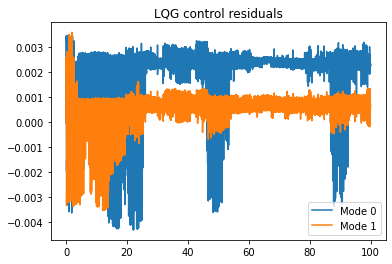

In [14]:
plot_tiptilt(zerns)
plt.title("LQG control residuals")

How about the commands?

Text(0.5, 1.0, 'LQG control inputs')

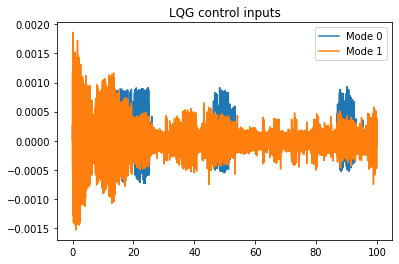

In [15]:
plot_tiptilt(commands)
plt.title("LQG control inputs")

and in theory if you add them you get a pseudo-open-loop

Text(0.5, 1.0, 'Pseudo-open-loop reconstruction')

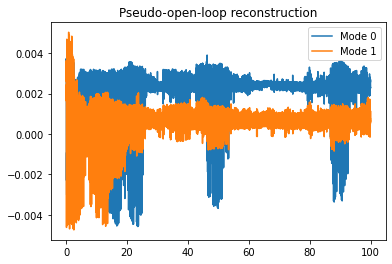

In [16]:
pol = zerns[2:] + commands
plot_tiptilt(pol)
plt.title("Pseudo-open-loop reconstruction")

That basically just looks like the residual - it seems like my R is just too high. But that's not all I can infer from this! For one thing, is the Kalman filter doing okay?

In [17]:
dmc2wf = np.load("../data/bestflats/lodmc2wfe.npy")
actual_openloop = np.load("../data/openloop/ol_amp_0.003_f_5_z_stamp_05_11_2021_08_46_26.npy")[:,:2]# * dmc2wf
for i in range(2):
    print(f"Mode {i} RMS ratio: {rms(zerns[:,i]) / rms(actual_openloop[:,i])}")

Mode 0 RMS ratio: 0.8279627032475785
Mode 1 RMS ratio: 0.404198461800716


In [18]:
ident = SystemIdentifier(actual_openloop * dmc2wf)
klqg = ident.make_klqg_from_openloop()

Solved discrete ARE.
Solved discrete ARE.


In [19]:
klqg.improvement()

100%|██████████| 999/999 [00:00<00:00, 1004.05it/s]


4.813450693407684

100%|██████████| 10002/10002 [00:00<00:00, 41370.22it/s]


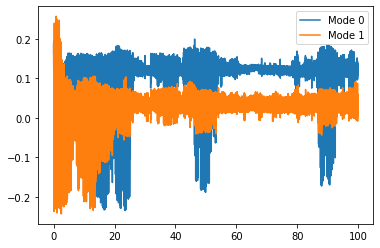

In [20]:
reconstructed_states = klqg.filter(pol[:,:2] * dmc2wf, klqg.x)
reconstructed_measure = reconstructed_states @ klqg.C.T
plot_tiptilt(reconstructed_measure - pol[:,:2])

Test for the Kalman filter: add a normal perturbation into the original OL signal and see how much of it we can remove.

Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.


100%|██████████| 10004/10004 [00:00<00:00, 54033.01it/s]


Text(0.5, 1.0, 'Reconstruction with KF, rms ratio = 0.0189823')

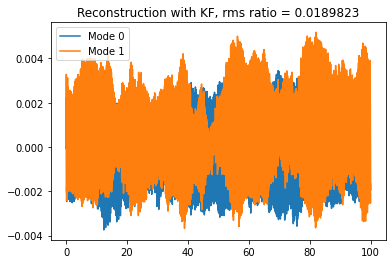

In [48]:
sd = 1e-1
ol_noisy = actual_openloop + np.random.normal(0, sd, actual_openloop.shape)
klqg = ident.make_klqg_from_openloop(model_atm=True, model_vib=True)
# start mods
klqg.W /= 1e15
klqg.V = np.eye(2) * sd ** 2
# end mods
klqg.recompute()
klqg.x *= 0
ol_recon = klqg.filter(ol_noisy, np.zeros(klqg.state_size,)) @ klqg.C.T
plot_tiptilt(actual_openloop - ol_recon)
plt.title(f"Reconstruction with KF, rms ratio = {rms(actual_openloop - ol_recon) / sd}")

In [36]:
klqg.W

array([[2.54720417e-08, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.62893585e-11, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000

In [35]:
print(klqg)

Kalman-LQG observer and controller with state size 16, input size 2 and measurement size 2


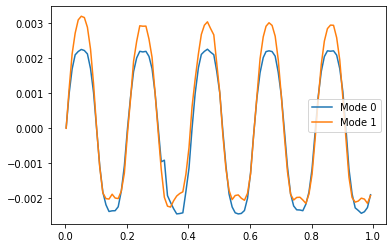

In [27]:
plot_tiptilt(actual_openloop[:100], n=100)

In [28]:
np.diff(times)

array([0.00954652, 0.00978088, 0.00986624, ..., 0.00987983, 0.01000667,
       0.00995708])

In [29]:
np.mean(np.diff(times))

0.009996959022149006